<a href="https://colab.research.google.com/github/naufal918/Pendeteksi-Larva/blob/main/skripsi_fiela_cnn_deteksi_larva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Gradcam support tools
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [94]:
import random

SEED = 123

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

session_conf = tf.compat.v1.ConfigProto( intra_op_parallelism_threads=1, inter_op_parallelism_threads=1 )
sess = tf.compat.v1.Session( graph=tf.compat.v1.get_default_graph(), config=session_conf )
tf.compat.v1.keras.backend.set_session(sess)

In [95]:
import random

SEED = 123

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

session_conf = tf.compat.v1.ConfigProto( intra_op_parallelism_threads=1, inter_op_parallelism_threads=1 )
sess = tf.compat.v1.Session( graph=tf.compat.v1.get_default_graph(), config=session_conf )
tf.compat.v1.keras.backend.set_session(sess)

In [96]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [97]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

#liat kaggle.json nya dari sini fi : https://www.kaggle.com/settings/account terus pilih API-create new token

In [98]:
!chmod 600 /content/kaggle.json

In [99]:
!pip install kaggle

In [100]:
import kaggle

# Replace 'username/dataset' with the actual Kaggle dataset you want to download
dataset_name = 'mrgopal918/larva-detection'
# Authenticate with Kaggle API
kaggle.api.authenticate()

# Download the dataset
kaggle.api.dataset_download_files(dataset_name, unzip=True)

##Membaca directory dari dataset nya

In [101]:
data_dir = r'/content/dataset'

## Membaca path data

In [102]:
import os
import pandas as pd
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definisikan fungsi untuk mendapatkan data paths dan label kelas
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)

        if not os.path.isdir(foldpath):
            continue

        filelist = os.listdir(foldpath)

        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels

### Menyimpan path dalam dataframe

In [103]:
# Generate data paths dengan label kelas
files, classes = define_paths(data_dir)

In [104]:
# Definisikan fungsi untuk menggabungkan data paths dan label kelas menjadi DataFrame
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

In [105]:
# Buat DataFrame dengan data paths dan label kelas
df = define_df(files, classes)

In [106]:
# Cetak lima baris pertama dari DataFrame untuk memeriksa hasilnya
print(df.head())

                                           filepaths labels
0  /content/dataset/train/IMG_0958_jpg.rf.ddf0aeb...  train
1  /content/dataset/train/IMG_9040_jpg.rf.acfe3e0...  train
2  /content/dataset/train/IMG_9719_jpg.rf.c671cd8...  train
3  /content/dataset/train/IMG_9455_jpg.rf.2aa794a...  train
4  /content/dataset/train/IMG_9639_jpg.rf.e14fa4c...  train


In [107]:
print(df)

                                             filepaths labels
0    /content/dataset/train/IMG_0958_jpg.rf.ddf0aeb...  train
1    /content/dataset/train/IMG_9040_jpg.rf.acfe3e0...  train
2    /content/dataset/train/IMG_9719_jpg.rf.c671cd8...  train
3    /content/dataset/train/IMG_9455_jpg.rf.2aa794a...  train
4    /content/dataset/train/IMG_9639_jpg.rf.e14fa4c...  train
..                                                 ...    ...
720  /content/dataset/test/IMG_9836_jpg.rf.43bf69c1...   test
721  /content/dataset/test/IMG_9702_jpg.rf.c52d8497...   test
722  /content/dataset/test/IMG_9283_jpg.rf.d9cdb6ae...   test
723  /content/dataset/test/IMG_9280_jpg.rf.ce50a50f...   test
724  /content/dataset/test/IMG_9148_jpg.rf.518cc957...   test

[725 rows x 2 columns]


In [108]:
# Directory with our training dandelion pictures
train_larva_dir = os.path.join('/content/dataset/train')

# Directory with our validation dandelion pictures
valid_larva_dir = os.path.join('/content/dataset/valid')

# Directory with our validation dandelion pictures
test_larva_dir = os.path.join('/content/dataset/test')


In [109]:
train_larva_names = os.listdir(train_larva_dir)
print(train_larva_names[:10])

validation_larva_hames = os.listdir(valid_larva_dir)
print(validation_larva_hames[:10])


['IMG_0958_jpg.rf.ddf0aebc09a049b820cd3f19896f5e96.jpg', 'IMG_9040_jpg.rf.acfe3e0e0c89c24e399b465333aee09d.jpg', 'IMG_9719_jpg.rf.c671cd89e0e4ad16a1a8358ada8d0b36.jpg', 'IMG_9455_jpg.rf.2aa794adfc26d791c7ce0895e932a10d.jpg', 'IMG_9639_jpg.rf.e14fa4c0d699422d001bf22aa9d409e2.jpg', 'IMG_9696_jpg.rf.cbfa5c974cd0267a0804447811c36a93.jpg', 'IMG_9204_jpg.rf.557de9ffd26b0589054681d3f7222d81.jpg', 'IMG_9772_jpg.rf.81334c683c012e756070d0b55aa4d25e.jpg', 'IMG_9769_jpg.rf.30cdf5dae2800c17938780b309d8ef38.jpg', 'IMG_9616_jpg.rf.80d30a7ea4487b87564fd856dfeb308a.jpg']
['IMG_9023_jpg.rf.ef51ea1d44f7320ff51dfbb18234af85.jpg', 'IMG_9594_jpg.rf.e5c9352cdcfaa556eedc22020b587c6d.jpg', 'IMG_9818_jpg.rf.c3a6355bbfc5b859aebac01da957b393.jpg', 'IMG_9823_jpg.rf.574fa82a03d7154c9bc3346091ceeb73.jpg', 'IMG_9602_jpg.rf.dcbd718c7d09d2194f98a47b2078191b.jpg', 'IMG_9164_jpg.rf.3fcc69002a531e3b5a1b3a4c73f38bc1.jpg', 'IMG_9392_jpg.rf.7af6bb3d9f144bafb55e4884610badf9.jpg', 'IMG_9722_jpg.rf.e7143ac1e1a9d212ba68a4d0408f2

In [110]:
print('total training larva images:', len(os.listdir(train_larva_dir)))
print('total validation larva images:', len(os.listdir(valid_larva_dir)))
print('total test larva images:', len(os.listdir(test_larva_dir)))



total training larva images: 365
total validation larva images: 289
total test larva images: 71


## Pre-proses load data
### penentuan parameter data generator

In [111]:
# define model parameters
img_size = (256, 256)
channels = 3 # either BGR or Grayscale
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
# mencari faktor dari jumlah test set yang kurang dari sama dengan 80
ts_length = len(test_larva_dir)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

In [112]:
test_batch_size

21

In [113]:
sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80])

[1, 3, 7, 21]

In [114]:
test_steps

1

In [115]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

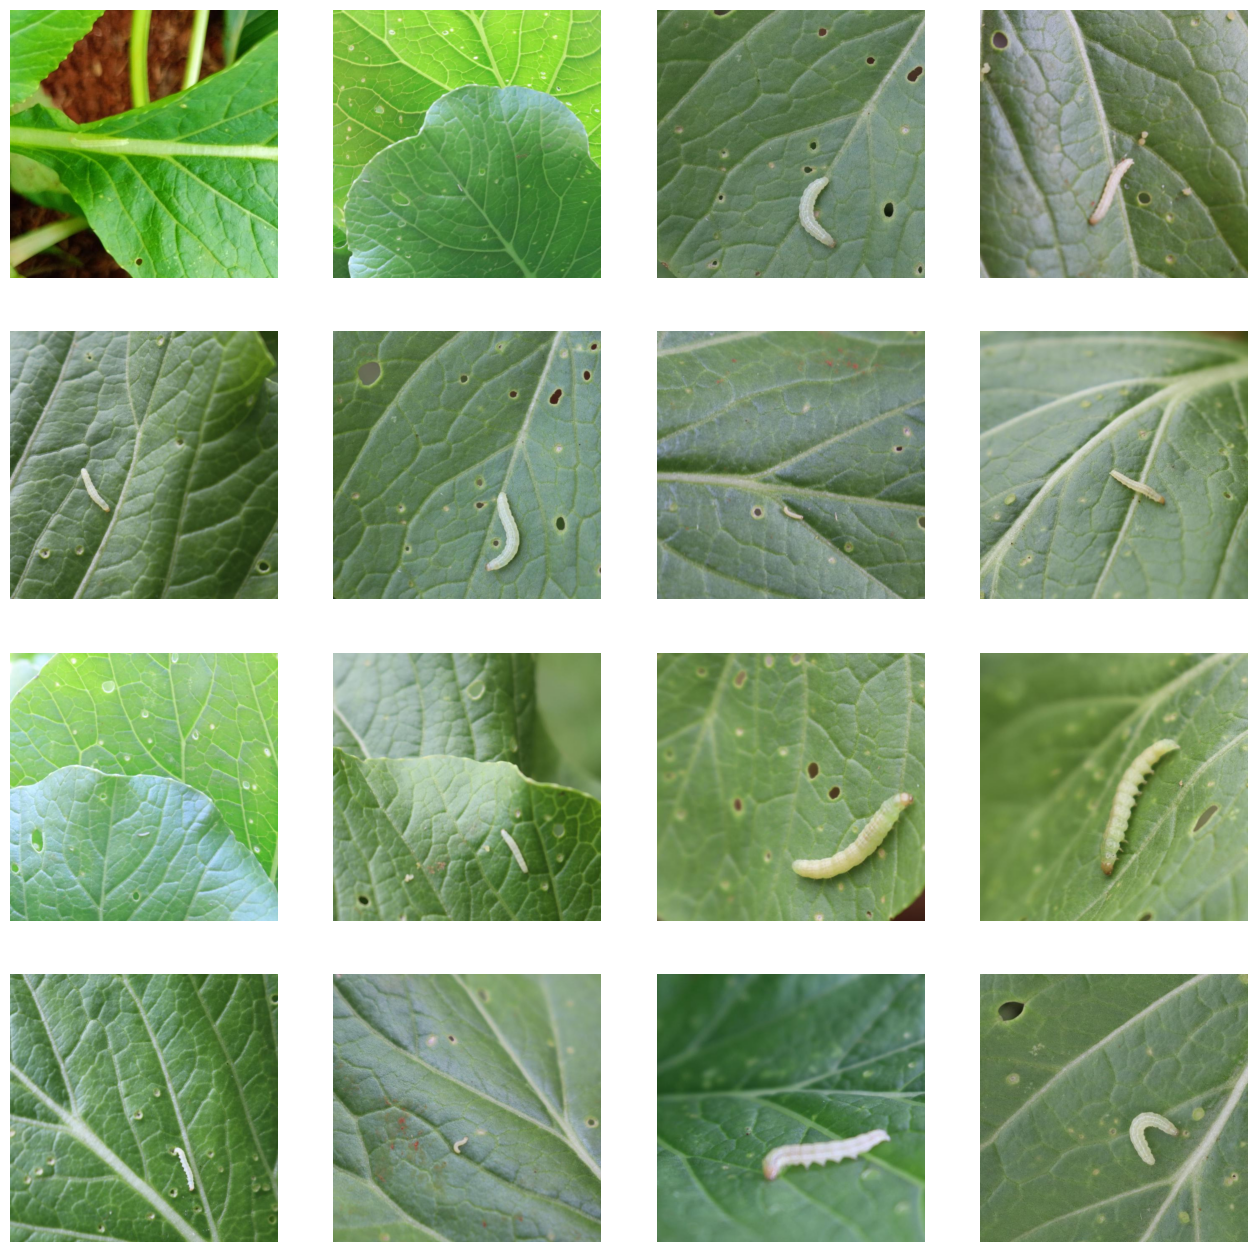

In [116]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_dandelion_pic = [os.path.join(train_larva_dir, fname)
                for fname in train_larva_names[pic_index-8:pic_index]]
next_grass_pic = [os.path.join(valid_larva_dir, fname)
                for fname in validation_larva_hames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_dandelion_pic + next_grass_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

#### Data Preprocessing

Menggunakan `keras.preprocessing.image.ImageDataGenerator` class untuk membuat  train and validation dataset dan normalize data.
Sangat penting untuk melakukan normalize data karena data akan diproses oleh CNN untuk improve performance secara keseluruhan. Disini kita akan menggunakan `rescale` parameter untuk scale our image pixel values dari [0, 255] ke [0,1].

Disetiap generator, kita menentukan source directory dari images, classes, input image size, batch size (seberapa banyak images yang akan diproses), dan class mode.

In [117]:
print(len(train_larva_dir))

22


In [118]:
print(len(valid_larva_dir))

22


In [119]:
print(len(test_larva_dir))

21


In [120]:
from keras.preprocessing.image import ImageDataGenerator
train_larva_dir = '/content/dataset/'
train_datagen = ImageDataGenerator(rescale=1/255)

    # YOUR IMAGE SIZE SHOULD BE 150x150
train_generator=train_datagen.flow_from_directory(directory=train_larva_dir,
                                                        target_size=(150, 150),
                                                        batch_size=10,
                                                        class_mode='binary')

valid_larva_dir = '/content/dataset/'
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(directory=valid_larva_dir,
                                                            target_size=(150, 150),
                                                            batch_size=10,
                                                            class_mode='binary')

test_larva_dir = '/content/dataset/'
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(directory=test_larva_dir,
                                                            target_size=(150, 150),
                                                            batch_size=10,
                                                            class_mode='binary')

Found 722 images belonging to 3 classes.
Found 722 images belonging to 3 classes.
Found 722 images belonging to 3 classes.


In [121]:
print(len(train_generator))

73



## Building the Model from Scratch

Memulai menentukan model:

Step 1 import tensorflow.

In [122]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [123]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2),
                                                           activation='relu', padding = 'same',
                                                           input_shape = (200, 200, 3),
                                                           kernel_initializer='he_normal',
                                                           bias_initializer='zeros'),
                                    tf.keras.layers.MaxPool2D(pool_size = (2,2) ),
                                    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2),
                                                           activation='relu', padding = 'same',
                                                           kernel_initializer='he_normal',
                                                           bias_initializer='zeros'),
                                    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
                                    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2),
                                                           activation='relu', padding = 'same',
                                                           kernel_initializer='he_normal',
                                                           bias_initializer='zeros'),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [124]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 100, 100, 32)      2432      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 6, 6, 64)          36928     
                                                                 
 flatten_7 (Flatten)         (None, 2304)             

In [125]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [127]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator

# Inisialisasi ukuran gambar (asumsi)
img_width, img_height = 150, 150

# Create your model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ... (ImageDataGenerator and generator setup code)
train_generator=train_datagen.flow_from_directory(directory=train_larva_dir,
                                                        target_size=(150, 150),
                                                        batch_size=10,
                                                        class_mode='binary')

valid_larva_dir = '/content/dataset/'
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(directory=valid_larva_dir,
                                                            target_size=(150, 150),
                                                            batch_size=10,
                                                            class_mode='binary')

test_larva_dir = '/content/dataset/'
validation_datagen = ImageDataGenerator(rescale=1/255)
test_generator = validation_datagen.flow_from_directory(directory=test_larva_dir,
                                                            target_size=(150, 150),
                                                            batch_size=10,
                                                            class_mode='binary')

# Now you can train the model
model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=20,
          validation_data=validation_generator, validation_steps=len(validation_generator))

# And evaluate it on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Found 722 images belonging to 3 classes.
Found 722 images belonging to 3 classes.
Found 722 images belonging to 3 classes.
Epoch 1/20
73/73 [==============================] - 27s 354ms/step - loss: -836.4166 - accuracy: 0.5042 - val_loss: -3309.6372 - val_accuracy: 0.5042
Epoch 2/20
73/73 [==============================] - 18s 247ms/step - loss: -10212.4551 - accuracy: 0.5042 - val_loss: -19968.1055 - val_accuracy: 0.5042
Epoch 3/20
73/73 [==============================] - 16s 225ms/step - loss: -35436.1758 - accuracy: 0.5042 - val_loss: -53731.6719 - val_accuracy: 0.5042
Epoch 4/20
73/73 [==============================] - 17s 236ms/step - loss: -77888.6328 - accuracy: 0.5042 - val_loss: -103737.3828 - val_accuracy: 0.5042
Epoch 5/20
73/73 [==============================] - 17s 237ms/step - loss: -134818.6875 - accuracy: 0.5042 - val_loss: -168211.0000 - val_accuracy: 0.5042
Epoch 6/20
73/73 [==============================] - 17s 236ms/step - loss: -205109.9688 - accuracy: 0.5042 - val

In [128]:
history = model.fit(train_generator,
      steps_per_epoch=8,
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - 2s 231ms/step - loss: -2151571.7500 - accuracy: 0.4500 - val_loss: -2224554.5000 - val_accuracy: 0.4875
Epoch 2/15
8/8 [==============================] - 2s 205ms/step - loss: -3458207.2500 - accuracy: 0.5278 - val_loss: -3396153.2500 - val_accuracy: 0.5625
Epoch 3/15
8/8 [==============================] - 2s 237ms/step - loss: -2258375.2500 - accuracy: 0.5625 - val_loss: -3027300.7500 - val_accuracy: 0.4875
Epoch 4/15
8/8 [==============================] - 3s 382ms/step - loss: -3059012.0000 - accuracy: 0.5000 - val_loss: -3456017.5000 - val_accuracy: 0.4750
Epoch 5/15
8/8 [==============================] - 2s 220ms/step - loss: -3149423.5000 - accuracy: 0.5125 - val_loss: -2375830.0000 - val_accuracy: 0.4750
Epoch 6/15
8/8 [==============================] - 2s 238ms/step - loss: -3942617.2500 - accuracy: 0.4750 - val_loss: -3312901.0000 - val_accuracy: 0.4250
Epoch 7/15
8/8 [==============================] - 2s 230ms/step - loss: -180

In [129]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] #/ 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

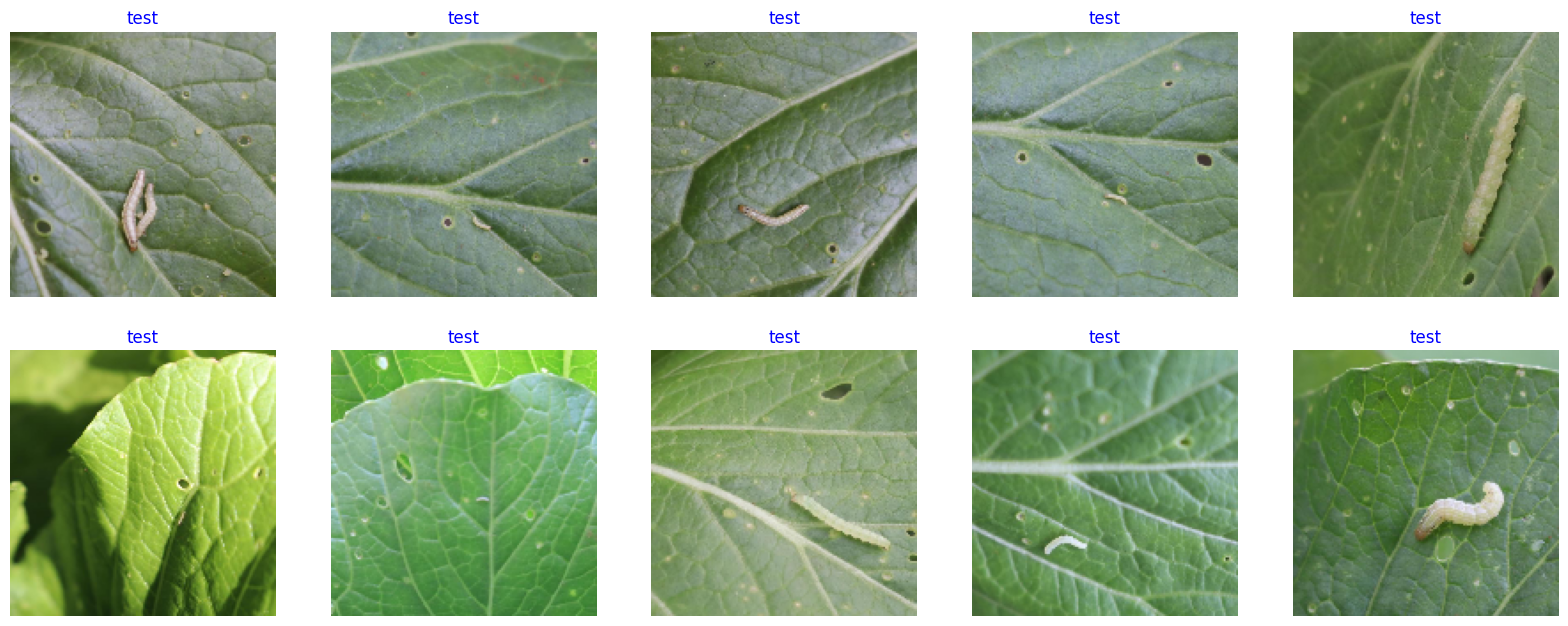

In [130]:
show_images(train_generator)

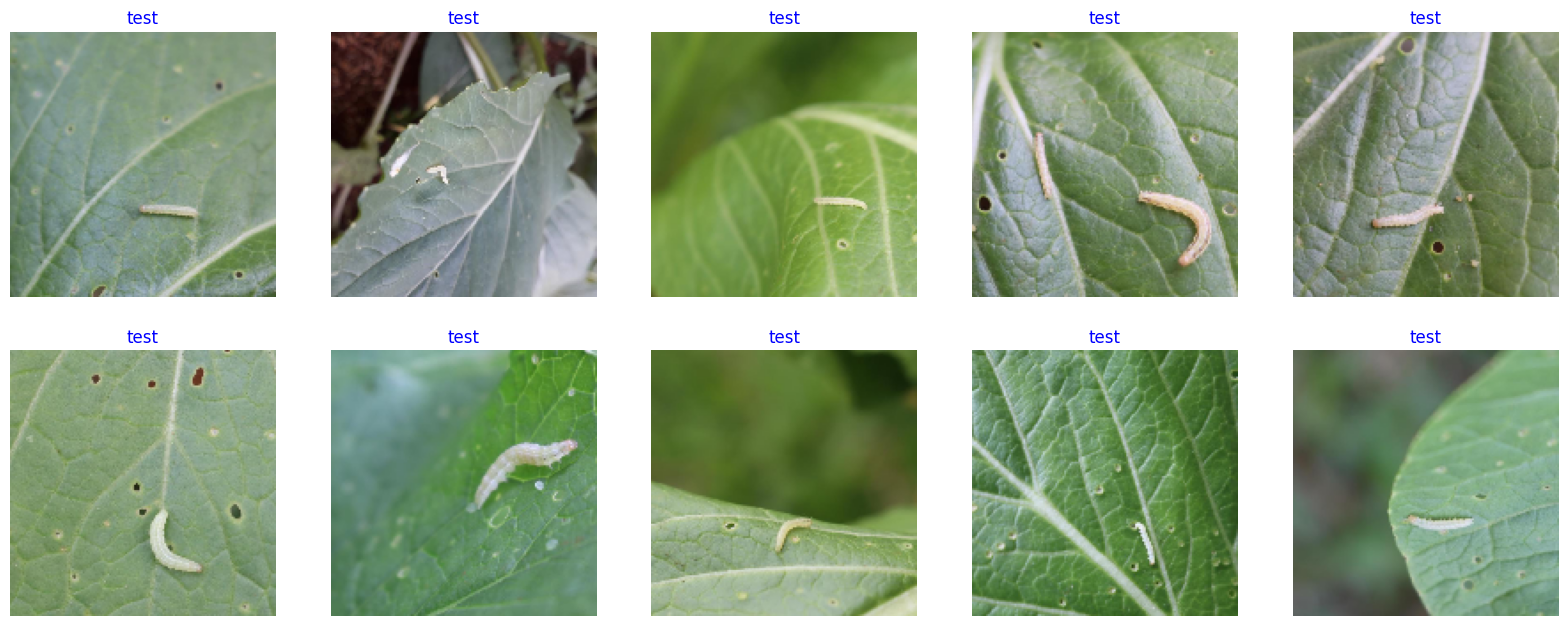

In [131]:
show_images(validation_generator)

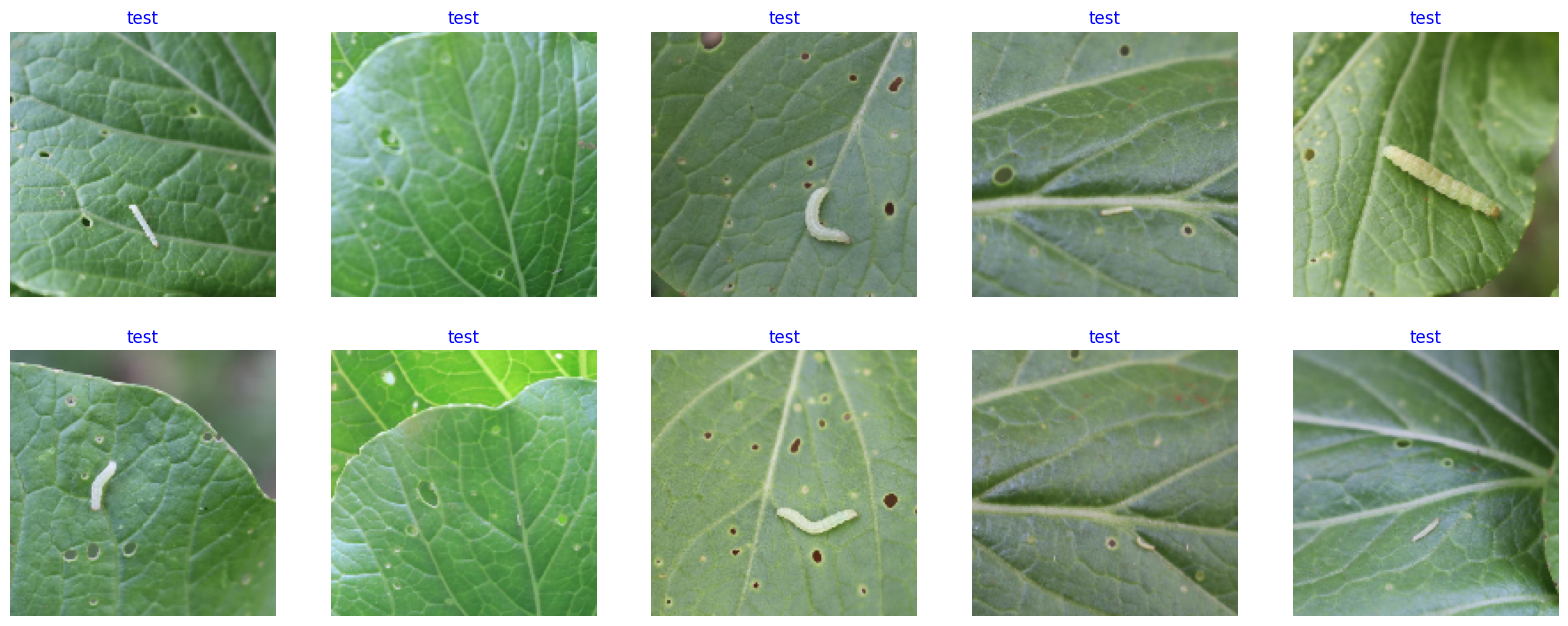

In [132]:
show_images(test_generator)

## Pengaturan Training Model
### Callback

In [133]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

In [134]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [135]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

## Train a model using Functional API
### Model VGG19 (untuk fine tuning)

In [136]:
# Create Model Structure
img_size = (256, 256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_generator.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.vgg19.VGG19(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

# additional layer
x = Flatten()(base_model.output)
x = Dropout(rate=0.2)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(class_count, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, outputs)

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

80134624/80134624 [==============================] - 1s 0us/step


In [137]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

## Train the Functional API Model

### HyperParameter untuk training model

In [138]:
batch_size = 64   # set batch size for training
epochs = 100   # number of all epochs in training
patience = 3   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 10   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_generator.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [139]:
history = model.fit(x= train_generator, epochs= 20, verbose= 0, callbacks= callbacks,
                    validation_data= validation_generator, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?
y
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


ValueError: ignored

## graphic plotting

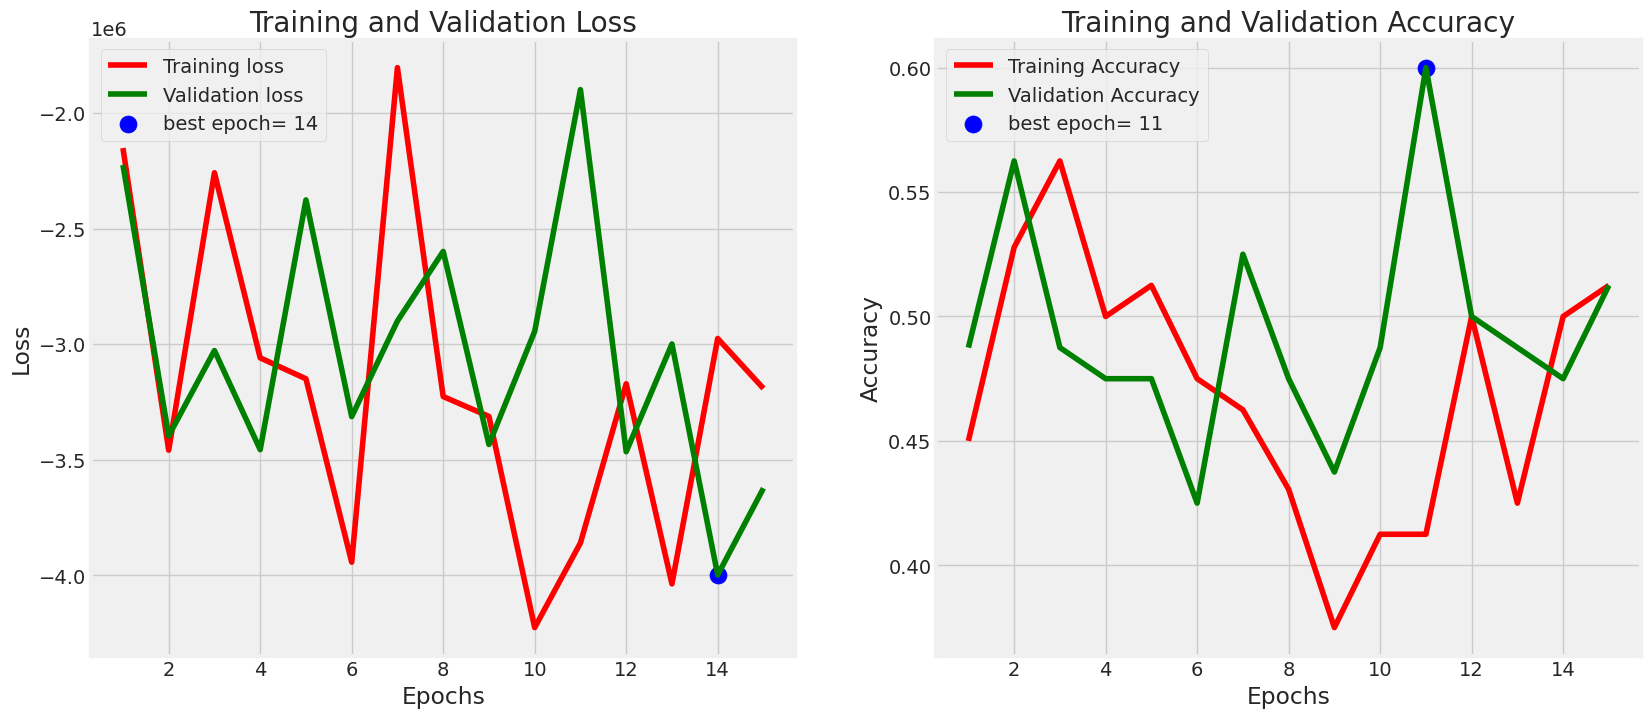

In [140]:
plot_training(history)

### Evaluasi Model (train_df, valid_df, test_df)

In [147]:
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error

# Prediksi pada data train
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)

# Prediksi pada data validasi
y_valid_true = validation_generator.classes
y_valid_pred = model.predict(validation_generator)

# Prediksi pada data test
y_test_true = test_generator.classes
y_test_pred = model.predict(test_generator)

# Evaluasi pada data train
train_accuracy = accuracy_score(y_train_true, np.round(y_train_pred)) # Ganti ini sesuai dengan metrik evaluasi yang sesuai

# Evaluasi pada data validasi
validation_accuracy = accuracy_score(y_valid_true, np.round(y_valid_pred)) # Ganti ini sesuai dengan metrik evaluasi yang sesuai

# Evaluasi pada data test
test_accuracy = accuracy_score(y_test_true, np.round(y_test_pred)) # Ganti ini sesuai dengan metrik evaluasi yang sesuai

print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", validation_accuracy)
print("Test Accuracy:", test_accuracy)

73/73 [==============================] - 6s 77ms/step
Train Accuracy: 0.5041551246537396
Validation Accuracy: 0.5041551246537396
Test Accuracy: 0.5041551246537396


### Evaluasi lanjutan test_df

In [149]:
preds = model.predict_generator(test_generator)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

Confusion Matrix, Without Normalization
[[ 70   0   0]
 [364   0   0]
 [288   0   0]]
              precision    recall  f1-score   support

        test       0.10      1.00      0.18        70
       train       0.00      0.00      0.00       364
       valid       0.00      0.00      0.00       288

    accuracy                           0.10       722
   macro avg       0.03      0.33      0.06       722
weighted avg       0.01      0.10      0.02       722



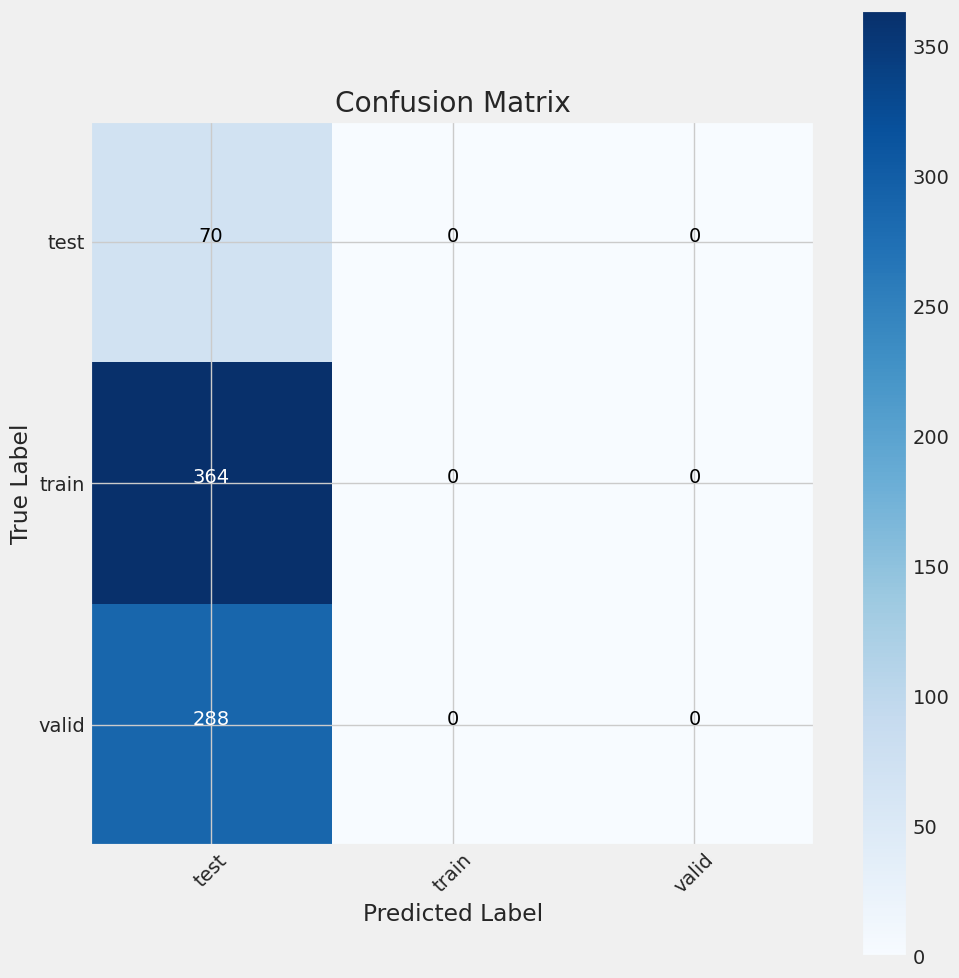

In [151]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cmtrx = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm= cmtrx, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_generator.classes, y_pred, target_names= classes))

## Menyimpan Model VGG19(fine tuned)

In [154]:
model_name = model.input_names[0][:-6]
subject = 'skripsi_fiela'
acc = test_accuracy * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as conv2d_16-skripsi_fiela-50.42.h5
weights were saved as conv2d_16-skripsi_fiela-weights.h5


## Import saved model

In [173]:
model_path = '/content/conv2d_16-skripsi_fiela-50.42.h5'

In [174]:
model_load = tf.keras.models.load_model(model_path)

In [175]:
model_layers = [layer.name for layer in model_load.layers]

In [176]:
n = 4
img_path = test_generator.filepaths[n]
true_label = test_generator.classes[n]

img = keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    # `array` is a float32 Numpy array of shape (299, 299, 3)
array = keras.preprocessing.image.img_to_array(img) / 255
    # We add a dimension to transform our array into a "batch"
array1 = np.expand_dims(array, axis=0)

In [177]:
array1.shape

(1, 256, 256, 3)

In [178]:
array1[0][0][100]

array([0.25882354, 0.3019608 , 0.        ], dtype=float32)

In [171]:
hasil = model_load.predict(array1)

ValueError: ignored

In [179]:
print(classes[np.argmax(hasil[0])])
print(f"True : {true_label}")

NameError: ignored

## Membuat GRAD-CAM
### Prediction and Bounding Box Function

In [180]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

In [181]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

### test heatmap

In [182]:
model_layers[-10:]

['conv2d_16', 'max_pooling2d_13', 'flatten_11', 'dense_15']

In [184]:
# Periksa dan dapatkan nama-nama layer dalam model Anda
model_layers = [layer.name for layer in model.layers]
print(model_layers)

['conv2d_16', 'max_pooling2d_13', 'flatten_11', 'dense_15']


In [188]:
# Periksa jumlah total layer dalam model Anda
total_layers = len(model.layers)
print(total_layers)

4


In [190]:
# VGG19s last convolution layer
last_conv_layer_name = model_layers[2]
last_conv_layer_name

'flatten_11'

In [191]:
# Print what the top predicted class is
preds = model_load.predict(array1)
# print("Predicted:", decode_predictions(preds, top=1)[0])
print(preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(array1, model_load, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

ValueError: ignored

In [192]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    (superimposed_img.save(cam_path))

    # Display Grad CAM
    display(Image(img_path))
    display(Image(cam_path))

    return '/content/'+ str(cam_path)

In [193]:
def grad_cam_to_mask(img_path, cam_path):
    # Read the images
    img = cv2.imread(cam_path)
    img2 = cv2.imread(img_path)

    # Resizing the image
    image = cv2.resize(img, (700, 600))
    image2 = cv2.resize(img2, (700, 600))

    # Convert Image to Image HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Defining lower and upper bound HSV values
    lower = np.array([0, 100, 20])
    upper = np.array([35, 255, 255])

    # Defining mask for detecting color
    mask = cv2.inRange(hsv, lower, upper)

    # Bitwise-AND mask and original image
    result = cv2.bitwise_and(image2,image2, mask= mask)


    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.tight_layout()

    plt.axis('off')

    plt.savefig('heatmap_mask.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
    heatmap_mask_path = '/content/heatmap_mask.jpg'

    return heatmap_mask_path

In [194]:
def draw_bounding_area(img_path, heatmap_mask_path, ground_truth_label, label, output_filename):
    im = cv2.imread(heatmap_mask_path)
    im_xray = cv2.imread(img_path)

#     assert im is not None, "file could not be read, check with os.path.exists()"

    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    imgray = cv2.resize(imgray, (700, 600))
    im2 = cv2.resize(im_xray, (700, 600))
    # imgray2 = cv2.cvtColor(im_xray, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 20, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    result = cv2.drawContours(im2, contours, -1, (0,255,0), 3)

    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

    # save image
    plt.axis('off')

    prediction_text = f"Ground Truth: {label}, prediction: [{ground_truth_label}]"
    plt.title(prediction_text, color= 'blue', fontsize= 12)

    plt.savefig(output_filename, dpi=300, bbox_inches='tight', pad_inches=0)

    plt.show()

In [207]:
def prediction(test_data_index, output_filename='bounding_crocidolomia_pavonana'):
    # image's path for prediction
    test_pict = test_generator.iloc[test_data_index,:]
    img_path = test_pict.filepaths
    output_file = output_filename + '.jpg'

    # make prediction and heatmap
    heatmap, predict_label = image_to_heatmap_and_predict(img_path = img_path, model = model_load, ground_truth_label = test_pict.labels)

    # generate grad cam
    grad_cam_path = save_and_display_gradcam(img_path, heatmap)


    # make grad cam maks
    heatmap_mask_path = grad_cam_to_mask(img_path = img_path, cam_path = grad_cam_path)

    # draw bounding area
    draw_bounding_area(img_path = img_path, heatmap_mask_path = heatmap_mask_path, ground_truth_label = test_pict.labels, label = predict_label, output_filename=output_file)

In [204]:
prediction(33)

1/1 [==============================] - 0s 25ms/step


In [205]:
prediction(18)

1/1 [==============================] - 0s 26ms/step


In [ ]:
prediction(0)

In [206]:
prediction(14)

1/1 [==============================] - 0s 29ms/step
